In [86]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from random import sample
import math
import pickle as pk
from collections import Counter
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from random import sample
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc

In [3]:
from nltk.stem.snowball import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

### load features 

In [255]:
feature_path = '../data/feature'
featset_dict = {'pnp': 'pnp_feature.txt', 
                'bk': 'bk_feature.txt',
                'wh': 'wh_feature.txt'}

In [256]:
# load features to use
feat_list = ['label']
for f in os.listdir(feature_path):
    fp_feature_name = os.path.join(feature_path, f)
    with open(fp_feature_name, 'r') as fr:
        feature_names = [line.strip() for line in fr if not line.startswith("#")]
    feat_list += feature_names
    print(f"load {len(feature_names)} features")

load 6 features
load 30 features
load 25 features


### regular cv exp func

In [279]:
def cv_exp_perform(feature_arr, label_arr, clf):
    k_fold = KFold(10, shuffle=True)
    res_pre_list = []
    res_label_list = []
    mean_fpr = np.linspace(0, 1, 200)
    
    print('cv start')
    # perform 10-fold cv
    for k, (train_idx, test_idx) in enumerate(k_fold.split(label_arr)):
        train_x, train_y = feature_arr[train_idx], label_arr[train_idx]
        test_x, test_y = feature_arr[test_idx], label_arr[test_idx]

        clf.fit(train_x, train_y)
        res_pre_list.append(clf.predict_proba(test_x)[:,1])
        res_label_list.append(test_y)

    # combine result
    pre_res = np.concatenate(res_pre_list)
    label_arr_res = np.concatenate(res_label_list)
    
    fpr_t, tpr_t, thresh_t = metrics.roc_curve(label_arr_res, pre_res)
    mean_tpr = np.interp(mean_fpr, fpr_t, tpr_t)
    mean_tpr[0] = 0.0

    mean_auc = auc(mean_fpr, mean_tpr)
    mean_fpr_100 = mean_fpr * 100
    mean_tpr_100 = mean_tpr * 100
    
    i_1, = np.where(mean_fpr_100>=1.0)
    y_1 = mean_tpr_100[i_1[0]]
    
    roc_res_dict = {
            "mean_fpr_100": mean_fpr_100,
            "mean_tpr_100": mean_tpr_100,
            "mean_auc": mean_auc,
            "i_1": i_1,
            "y_1": y_1
            }

    return roc_res_dict

### regular cross validation exp with taser

In [280]:
# load dataset
f_tr = '../data/TSS_TA_training_data.csv'
df = pd.read_csv(f_tr, usecols=feat_list)
df.shape

(1500, 58)

In [281]:
df.head()

,label,n_bk_dom,n_blog_dom,n_forum_dom,ptile95_contain_hp,mean_contain_hp,med_contain_hp,n_follow_url,n_nofollow_url,r_follow_url,...,pds_fp_area_rfp_mean,pds_fp_area_rvp_mean,pds_html_con_mjr_ps_max_ratio,pds_html_con_mjr_ps_en,pds_vp_mjr_ps_max_ratio,pds_vp_mjr_ps_en,pds_fp_mjr_ps_max_ratio,pds_fp_mjr_ps_en,pds_head_sum_mean,pds_title_sum_mean
0,1,10,0,0,19.75,8.1667,5.5,6,9,0.4000,...,0.0024,0.0070,0.6724,1.3030,0.569,1.4936,0.5000,1.6769,0.8621,0.2759
1,1,9,0,0,23.50,6.6250,2.0,2,9,0.1818,...,0.0001,0.0002,0.7245,1.5640,0.000,0.0000,0.0000,0.4497,0.4694,0.1224
2,1,312,158,21,12.75,15.6195,8.0,1928,243,0.8881,...,0.0021,0.0204,1.0000,0.0000,0.000,0.0000,1.0000,0.0000,0.0000,0.0000
3,1,55,8,13,3.25,2.0000,1.0,171,100,0.6310,...,0.0018,0.0083,0.5000,1.9054,0.000,0.7889,0.5303,1.7734,0.1061,0.0000
4,1,7,0,0,6.00,4.0000,4.0,2,7,0.2222,...,0.0001,0.0004,0.8095,1.1590,0.000,0.2551,0.0000,0.1623,0.6429,0.1429


In [282]:
f_res = '../temp/exp_res_pkl/taser_regular_cv_result.pkl'

In [283]:
def taser_regular_cv(df, f_res, max_depth_x=1, n_estimators = 500):
    feature_arr = df.drop(['label'], axis=1).values
    label_arr = df['label'].values

    n_feature = int(feature_arr.shape[1])
    max_depth = int(n_feature * max_depth_x)
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=123)
    res = cv_exp_perform(feature_arr, label_arr, clf)
    with open(f_res, 'wb') as f:
        pk.dump(res, f)
    return res['mean_auc'], res['y_1']

In [284]:
taser_regular_cv(df, f_res, max_depth_x=1, n_estimators = 500)

cv start


(0.992710528430182, 93.4)

### regular cross validation exp with text based model

In [285]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]

    stem_doc = " ".join(stems)
    return stem_doc

In [286]:
def text_model_regular_cv(df, f_res, f_v_map):
    # Initialise the count vectorizer with the English stop words
    count_vectorizer = CountVectorizer(stop_words='english', 
                                       max_df=0.8, 
                                       max_features=5000,
                                       min_df=0.08,
                                       ngram_range=(1,2))
    
    # Fit and transform the processed titles
    count_data = count_vectorizer.fit_transform(df['text_processed'])
    count_data = count_data.toarray()
    
    # save vocabulary map for future test's usage
    with open(f_v_map, 'wb') as f:
        pk.dump(count_vectorizer.vocabulary_, f)

    label_arr = df['label'].values
    clf = MultinomialNB()
    
    res = cv_exp_perform(count_data, label_arr, clf)
    with open(f_res, 'wb') as f:
        pk.dump(res, f)
    return res['mean_auc'], res['y_1']

In [287]:
# load text data
f_tr_txt = '../data/text_data_for_TSS_TA_training_set.csv'
df_txt = pd.read_csv(f_tr_txt)
df_txt.shape

(1500, 3)

In [288]:
df_txt.head()

,domain,label,text_processed
0,123-hp-printer.com,1,hp com setup hp officejet pro setup guid get e...
1,123-hp-support.co,1,hp com setup officejet pro softwar instal toll...
2,123-hpenvy.com,1,how to instal hp envi printer 123-hpenvi com s...
3,123.hpsetup.online,1,hp printer isn t print hp com setup hpsetup on...
4,123hp-com.com,1,hp officejet printer setup and instal sorri yo...


In [289]:
res_path = '../temp/exp_res_pkl/text_model_regular_cv_result.pkl'
fp_token = '../temp/exp_res_pkl/nb_clf_vocabulary_map.pkl'
text_model_regular_cv(df_txt, res_path, fp_token)

cv start


(0.9627679820495153, 32.30437903804738)

### ROC curve plot

In [292]:
def roc_plot(result_path, f_res_list, y_lim):
    res = []
    for f in f_res_list:
        fp = os.path.join(result_path, f[0])
        res.append(pk.load(open(fp, 'rb')))

    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.set_xlabel('False Positive Rate (%,log scale)', fontsize=15, weight='bold')
    ax.set_ylabel('True Positive Rate (%)', fontsize=15, weight='bold')
    ax.set(xlim=[0, 100], ylim=y_lim)
    
    for i in range(len(res)):
        ax.plot(res[i]['mean_fpr_100'], 
                res[i]['mean_tpr_100'], 
                color=f_res_list[i][2], 
                label=f"Leave {f_res_list[i][1]} Out (AUC:{round(res[i]['mean_auc']*100,2)}%)", lw=2)
    
    ax.set_xscale('symlog')
    ax.set_xticks([0, 1, 10, 100], minor=False)
    ax.set_xticklabels(['0', '1', '10', '100'], minor=False)
    y_ticks = [y for y in range(y_lim[0], y_lim[1], 10)]
    y_tick_labels = [str(y) for y in range(y_lim[0], y_lim[1], 10)]
    ax.set_yticks(y_ticks, minor=False)
    ax.set_yticklabels(y_tick_labels, minor=True)
    
    ax.legend(loc="best", fontsize='large')

/Users/liujienan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


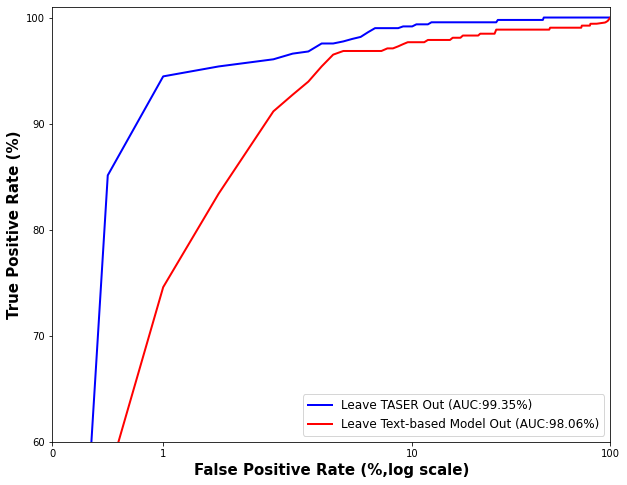

In [295]:
result_path = '../result'
f_res_list = [['regular_cv_result_taser.pkl', 'TASER', 'blue'], 
              ['regular_cv_result_text_model.pkl', 'Text-based Model', 'red']]
roc_plot(result_path, f_res_list, [60, 101])

/Users/liujienan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


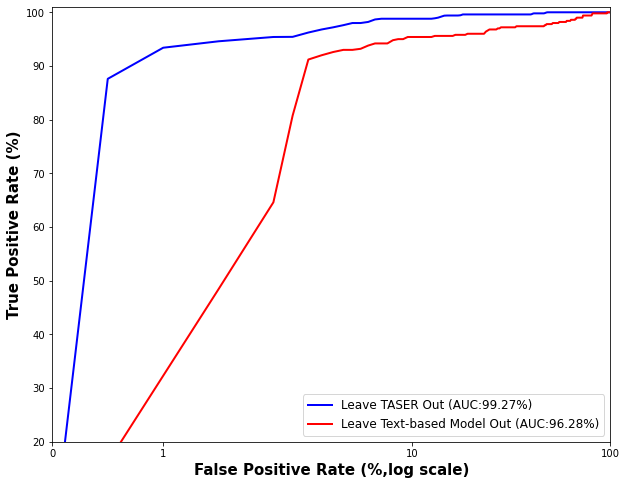

In [294]:
result_path = '../temp/exp_res_pkl'
f_res_list = [['taser_regular_cv_result.pkl', 'TASER', 'blue'], 
              ['text_model_regular_cv_result.pkl', 'Text-based Model', 'red']]
roc_plot(result_path, f_res_list, [20, 101])